# Convolutional neural networks for CIFAR100

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.models import load_model

import os

Using TensorFlow backend.


In [15]:
# Load the data: CIFAR100 with 20 class labels
(x_train_all, y_train_all), (x_test, y_test) = cifar100.load_data(label_mode='coarse')
num_classes = 20

# Convert class vectors to binary class matrices: we use the built-in Keras function for this
y_train_all = keras.utils.to_categorical(y_train_all, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

val_size = 6000
# make validation set
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=val_size, 
                                                              stratify = y_train_all, random_state = 1)
# let's take a subset of the training data first, for playing around
x_train_small = x_train[:10000]
y_train_small = y_train[:10000]

x_train_all = x_train_all.astype('float32')
x_train = x_train.astype('float32')
x_train_small = x_train_small.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train_all /= 255.0
x_train /= 255.0
x_train_small /= 255.0
x_val /= 255.0
x_test /= 255

# Labels
labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2'
]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_train_small.shape[0], 'small train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

x_train shape: (44000, 32, 32, 3)
44000 train samples
10000 small train samples
6000 validation samples
10000 test samples


## Model with Dynamic Learning Rate: only use maxpooling

In [24]:
def lr_schedule(epoch):
    lrate = 0.0005
    if epoch > 40:
        lrate = 0.00005
    if epoch > 70:
        lrate = 0.000005
    return lrate

test_model = Sequential()
#stack 1
test_model.add(Conv2D(96, (5, 5), padding='same',
                 input_shape=x_train.shape[1:], kernel_constraint=max_norm(2.)))
test_model.add(BatchNormalization())
test_model.add(Activation('relu'))
test_model.add(Conv2D(96, (5, 5), padding='same', kernel_constraint=max_norm(2.)))
test_model.add(BatchNormalization())
test_model.add(Activation('relu'))
test_model.add(MaxPooling2D(pool_size=(3, 3), strides = 2))
test_model.add(Dropout(0.1))

#stack2
test_model.add(Conv2D(128, (5, 5), padding='same', kernel_constraint=max_norm(2.)))
test_model.add(BatchNormalization())
test_model.add(Activation('relu'))
test_model.add(Conv2D(128, (5, 5), padding='same', kernel_constraint=max_norm(2.)))
test_model.add(BatchNormalization())
test_model.add(Activation('relu'))
test_model.add(MaxPooling2D(pool_size=(3, 3), strides = 2))
test_model.add(Dropout(0.2))

#stack3
test_model.add(Conv2D(256, (5, 5), padding='same', kernel_constraint=max_norm(2.)))
test_model.add(BatchNormalization())
test_model.add(Activation('relu'))
test_model.add(Conv2D(256, (5, 5), padding='same', kernel_constraint=max_norm(2.)))
test_model.add(BatchNormalization())
test_model.add(Activation('relu'))
test_model.add(MaxPooling2D(pool_size=(3, 3), strides = 2))
test_model.add(Dropout(0.2))

test_model.add(Flatten())
test_model.add(Dense(1024, kernel_constraint=max_norm(2.)))
test_model.add(Activation('relu'))
test_model.add(Dropout(0.5))
test_model.add(Dense(1024, kernel_constraint=max_norm(2.)))
test_model.add(Activation('relu'))
test_model.add(Dropout(0.5))

#output
test_model.add(Dense(num_classes))
test_model.add(Activation('softmax'))

test_model.summary()

epochs = 200
batch_size = 512

Adam = keras.optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
test_model.compile(loss='categorical_crossentropy',
              optimizer= Adam,
              metrics=['accuracy'])
filepath = 'step1_stage2_afterdylr.h5'

callbacks = [EarlyStopping(monitor='val_acc', patience=20),
             ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True), 
             LearningRateScheduler(lr_schedule)]

print('Not using data augmentation!')
history = test_model.fit(x_train_small, y_train_small,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          shuffle=True, callbacks = callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 32, 32, 96)        7296      
_________________________________________________________________
batch_normalization_61 (Batc (None, 32, 32, 96)        384       
_________________________________________________________________
activation_90 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 32, 32, 96)        230496    
_________________________________________________________________
batch_normalization_62 (Batc (None, 32, 32, 96)        384       
_________________________________________________________________
activation_91 (Activation)   (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 15, 15, 96)        0         
__________

10000/10000 [==============================] - 4s 382us/step - loss: 1.7465 - acc: 0.4421 - val_loss: 2.2911 - val_acc: 0.2977

Epoch 00017: val_acc improved from 0.29500 to 0.29767, saving model to step1_stage2_afterdylr.h5
Epoch 18/200
10000/10000 [==============================] - 4s 384us/step - loss: 1.6756 - acc: 0.4658 - val_loss: 2.3068 - val_acc: 0.3287

Epoch 00018: val_acc improved from 0.29767 to 0.32867, saving model to step1_stage2_afterdylr.h5
Epoch 19/200
10000/10000 [==============================] - 4s 381us/step - loss: 1.6193 - acc: 0.4767 - val_loss: 2.1083 - val_acc: 0.3632

Epoch 00019: val_acc improved from 0.32867 to 0.36317, saving model to step1_stage2_afterdylr.h5
Epoch 20/200
10000/10000 [==============================] - 4s 388us/step - loss: 1.5467 - acc: 0.4975 - val_loss: 2.0584 - val_acc: 0.3748

Epoch 00020: val_acc improved from 0.36317 to 0.37483, saving model to step1_stage2_afterdylr.h5
Epoch 21/200
10000/10000 [==============================] - 4

10000/10000 [==============================] - 4s 384us/step - loss: 0.0812 - acc: 0.9732 - val_loss: 2.5129 - val_acc: 0.5578

Epoch 00098: val_acc did not improve from 0.56100
Epoch 99/200
10000/10000 [==============================] - 4s 383us/step - loss: 0.0763 - acc: 0.9760 - val_loss: 2.5284 - val_acc: 0.5592

Epoch 00099: val_acc did not improve from 0.56100
Epoch 100/200
10000/10000 [==============================] - 4s 383us/step - loss: 0.0805 - acc: 0.9719 - val_loss: 2.5395 - val_acc: 0.5597

Epoch 00100: val_acc did not improve from 0.56100
Epoch 101/200
10000/10000 [==============================] - 4s 383us/step - loss: 0.0783 - acc: 0.9758 - val_loss: 2.5294 - val_acc: 0.5603

Epoch 00101: val_acc did not improve from 0.56100


6000/6000 [==============================] - 2s 266us/step
Training loss: 0.0119687244844 , training accuracy:  0.9986
Validation loss: 2.48075385952 , validation accuracy:  0.561


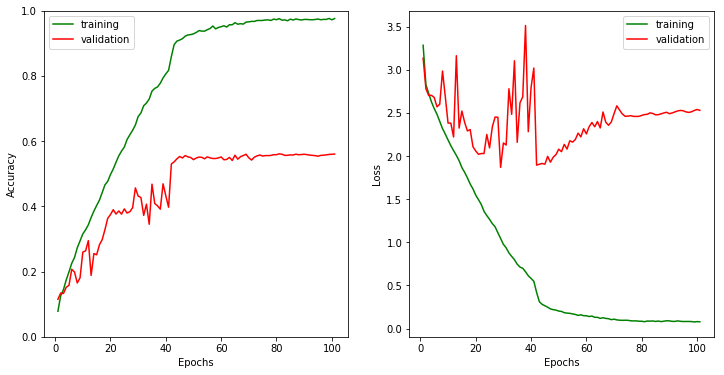

In [25]:
test_model.load_weights('step1_stage2_afterdylr.h5')
train_scores = test_model.evaluate(x_train_small, y_train_small, verbose=1)
val_scores = test_model.evaluate(x_val, y_val, verbose=1)

print('Training loss:', train_scores[0],', training accuracy: ',train_scores[1])
print('Validation loss:', val_scores[0],', validation accuracy: ',val_scores[1])

real_epochs = len(history.history['acc'])
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(np.arange(1,real_epochs+1,1),history.history['acc'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_acc'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0,1])
plt.legend()

# Note: loss is the loss function that is optimized for multi-class classification
# i.e. the multi-class version of cross-entropy error
plt.subplot(1,2,2)
plt.plot(np.arange(1,real_epochs+1,1),history.history['loss'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_loss'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

The model is powerfull enough.

The curve is smooth after epoch 40.

Overfitting.

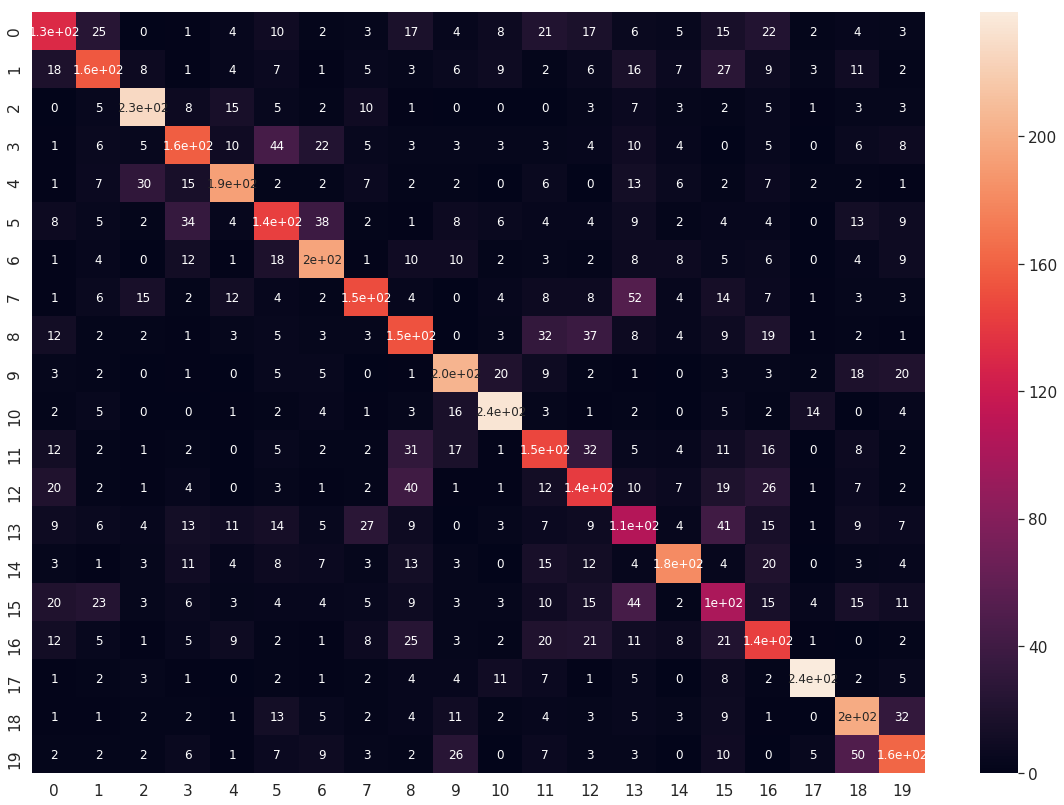

In [26]:
model=load_model('step1_stage2_afterdylr.h5')
y_val_pred = model.predict(x_val)
val_predicted_class = np.argmax(y_val_pred, axis=1)

val_cm = confusion_matrix(np.argmax(y_val, axis=1), val_predicted_class)

cm = pd.DataFrame(val_cm, range(20), range(20))
plt.figure(figsize = (20,14))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

High missclassification between types of animals (8,11,12,16), insects (7) and invertebrates (13), vehicle 1 (18) and vehicle 2 (19), food containers (3) and household electrical devices (5).

## Model with Dynamic Learning Rate: Mix Max & Avg Pooling (Step1 - Stage2)

In [30]:
def lr_schedule(epoch):
    lrate = 0.0005
    if epoch > 40:
        lrate = 0.00005
    if epoch > 70:
        lrate = 0.000005
    return lrate

test_model = Sequential()
#stack 1
test_model.add(Conv2D(96, (5, 5), padding='same',
                 input_shape=x_train.shape[1:], kernel_constraint=max_norm(2.)))
test_model.add(BatchNormalization())
test_model.add(Activation('relu'))
test_model.add(Conv2D(96, (5, 5), padding='same', kernel_constraint=max_norm(2.)))
test_model.add(BatchNormalization())
test_model.add(Activation('relu'))
test_model.add(MaxPooling2D(pool_size=(3, 3), strides = 2))
test_model.add(Dropout(0.1))

#stack2
test_model.add(Conv2D(128, (5, 5), padding='same', kernel_constraint=max_norm(2.)))
test_model.add(BatchNormalization())
test_model.add(Activation('relu'))
test_model.add(Conv2D(128, (5, 5), padding='same', kernel_constraint=max_norm(2.)))
test_model.add(BatchNormalization())
test_model.add(Activation('relu'))
test_model.add(MaxPooling2D(pool_size=(3, 3), strides = 2))
test_model.add(Dropout(0.2))

#stack3
test_model.add(Conv2D(256, (5, 5), padding='same', kernel_constraint=max_norm(2.)))
test_model.add(BatchNormalization())
test_model.add(Activation('relu'))
test_model.add(Conv2D(256, (5, 5), padding='same', kernel_constraint=max_norm(2.)))
test_model.add(BatchNormalization())
test_model.add(Activation('relu'))
test_model.add(AveragePooling2D(pool_size=(3, 3), strides = 2))
test_model.add(Dropout(0.2))

test_model.add(Flatten())
test_model.add(Dense(1024, kernel_constraint=max_norm(2.)))
test_model.add(Activation('relu'))
test_model.add(Dropout(0.5))
test_model.add(Dense(1024, kernel_constraint=max_norm(2.)))
test_model.add(Activation('relu'))
test_model.add(Dropout(0.5))

#output
test_model.add(Dense(num_classes))
test_model.add(Activation('softmax'))

test_model.summary()

epochs = 200
batch_size = 512

Adam = keras.optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
test_model.compile(loss='categorical_crossentropy',
              optimizer= Adam,
              metrics=['accuracy'])
filepath = 'step1_stage2_avrpooling.h5'

callbacks = [EarlyStopping(monitor='val_acc', patience=20),
             ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True), 
             LearningRateScheduler(lr_schedule)]

print('Not using data augmentation!')
history = test_model.fit(x_train_small, y_train_small,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          shuffle=True, callbacks = callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 32, 32, 96)        7296      
_________________________________________________________________
batch_normalization_79 (Batc (None, 32, 32, 96)        384       
_________________________________________________________________
activation_117 (Activation)  (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 32, 32, 96)        230496    
_________________________________________________________________
batch_normalization_80 (Batc (None, 32, 32, 96)        384       
_________________________________________________________________
activation_118 (Activation)  (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 15, 15, 96)        0         
__________


Epoch 00016: val_acc did not improve from 0.41983
Epoch 17/200
10000/10000 [==============================] - 4s 385us/step - loss: 1.2601 - acc: 0.5911 - val_loss: 2.0973 - val_acc: 0.4152

Epoch 00017: val_acc did not improve from 0.41983
Epoch 18/200
10000/10000 [==============================] - 4s 382us/step - loss: 1.1961 - acc: 0.6120 - val_loss: 2.2164 - val_acc: 0.3878

Epoch 00018: val_acc did not improve from 0.41983
Epoch 19/200
10000/10000 [==============================] - 4s 381us/step - loss: 1.1093 - acc: 0.6382 - val_loss: 2.0183 - val_acc: 0.4287

Epoch 00019: val_acc improved from 0.41983 to 0.42867, saving model to step1_stage2_avrpooling.h5
Epoch 20/200
10000/10000 [==============================] - 4s 381us/step - loss: 1.0399 - acc: 0.6612 - val_loss: 2.3698 - val_acc: 0.3858

Epoch 00020: val_acc did not improve from 0.42867
Epoch 21/200
10000/10000 [==============================] - 4s 381us/step - loss: 0.9836 - acc: 0.6753 - val_loss: 2.7656 - val_acc: 0.36

6000/6000 [==============================] - 2s 279us/step
Training loss: 0.00740174557311 , training accuracy:  0.9988
Validation loss: 2.39517573166 , validation accuracy:  0.571


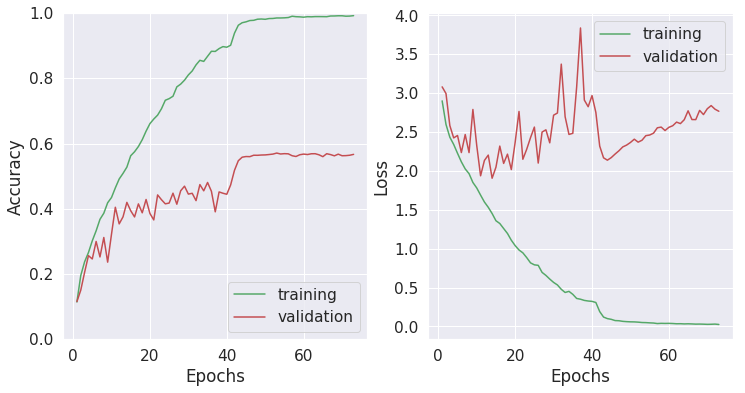

In [31]:
test_model.load_weights('step1_stage2_avrpooling.h5')
train_scores = test_model.evaluate(x_train_small, y_train_small, verbose=1)
val_scores = test_model.evaluate(x_val, y_val, verbose=1)

print('Training loss:', train_scores[0],', training accuracy: ',train_scores[1])
print('Validation loss:', val_scores[0],', validation accuracy: ',val_scores[1])

real_epochs = len(history.history['acc'])
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(np.arange(1,real_epochs+1,1),history.history['acc'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_acc'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim([0,1])
plt.legend()

# Note: loss is the loss function that is optimized for multi-class classification
# i.e. the multi-class version of cross-entropy error
plt.subplot(1,2,2)
plt.plot(np.arange(1,real_epochs+1,1),history.history['loss'],'g-',label='training')
plt.plot(np.arange(1,real_epochs+1,1),history.history['val_loss'],'r-',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

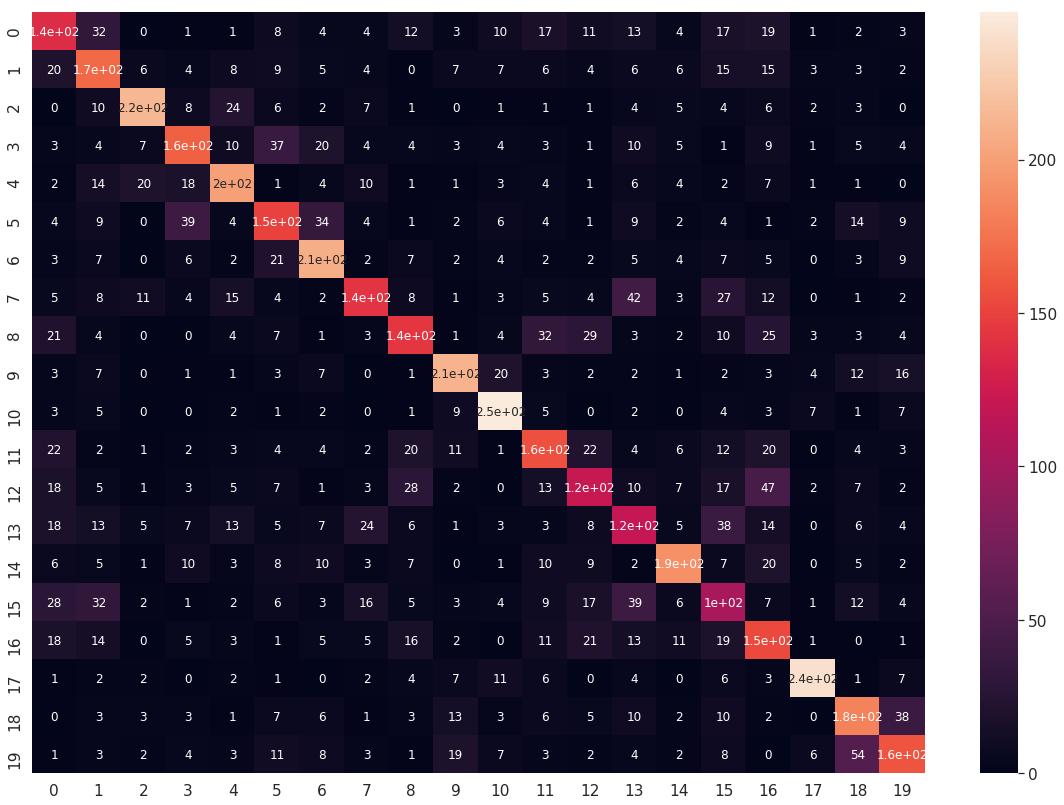

In [32]:
model=load_model('step1_stage2_avrpooling.h5')
y_val_pred = model.predict(x_val)
val_predicted_class = np.argmax(y_val_pred, axis=1)

val_cm = confusion_matrix(np.argmax(y_val, axis=1), val_predicted_class)

cm = pd.DataFrame(val_cm, range(20), range(20))
plt.figure(figsize = (20,14))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()

Missclassification between types of animals (8,11,12,16) is reduced slightly.
Missclassification between insects (7) and invertebrates (13) is also decreased. 

With the mix between average pooling and max pooling, the val acc is slightly higher than the model with only maxpooling by 1%. 